# 实验一
实现ResNet网络子模块，并在Kaggle猫/狗数据集上进行训练和测试

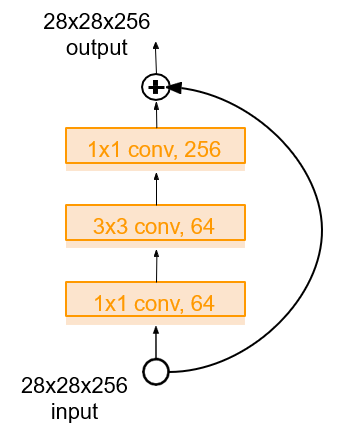


## 1.加载keras模块

In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras import layers
from keras.layers import Conv2D, AveragePooling2D,Input,BatchNormalization
from keras.layers import Activation, Dropout,Flatten,Dense,Concatenate
from keras.utils import to_categorical
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras import backend as K
import numpy as np

Using TensorFlow backend.


### 定义Inception网络结构



In [2]:
img_width, img_height = 50, 50

#声明Input layer并设置input_shape    
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
    bn_axis = 1
else:
    input_shape = (img_width, img_height, 3)
    bn_axis = 3#axis表示需要归一化的坐标轴，=3表示在通道数坐标轴进行归一化。    
    
input_img = Input (shape = input_shape)    
    
#根据上图设置以函数形式定义ResNet module的结构
x = layers.Conv2D(64, (1, 1), padding='same', kernel_initializer='he_normal')(input_img)
x = layers.BatchNormalization(axis=bn_axis)(x)
x = layers.Activation('relu')(x)

x = layers.Conv2D(64, (3,3), padding='same', kernel_initializer='he_normal')(x)
x = layers.BatchNormalization(axis=bn_axis)(x)
x = layers.Activation('relu')(x)

x = layers.Conv2D(256, (1, 1), padding='same', kernel_initializer='he_normal')(x)
x = layers.BatchNormalization(axis=bn_axis)(x)
x = layers.Activation('relu')(x)

x = layers.Conv2D(3, (1, 1), padding='same', kernel_initializer='he_normal')(x)
x = layers.BatchNormalization(axis=bn_axis)(x)
x = layers.Activation('relu')(x)
#定义叠加输入tensor和feature map的add layer
x = layers.add([x,input_img])
x = layers.Activation('relu')(x)

#定义fully connected layer
out = Flatten()(x)
out = Dense(48, activation='relu')(out)

#定义output layer
out = Dense(2, activation='softmax')(out)


#调用Model函数声明model
model = Model(input_img, out)


#编译整个网络，声明loss函数和优化器、metrics
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

### 查看model架构



In [3]:
model.summary()

### 定义ImageDataGenerator


In [4]:
train_data_dir = r'H:\AI_kejian\11.06\dogs-vs-cats\train'
validation_data_dir = r'H:\AI_kejian\11.06\dogs-vs-cats\validation'
nb_train_samples = 10835
nb_validation_samples = 4000
epochs = 1
batch_size = 5#一次训练取5个样本


# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    #缩放，值将在执行其他处理前乘到整个图像上，变为【0-1】的值
    shear_range=0.2,# 随机错切变换角度
    zoom_range=0.2,# 随机缩放范围
    horizontal_flip=True)# 一半图像水平翻转

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)


#调用flow_from_directory函数读取training数据和validation数据，注意class_mode的设置
train_generator = train_datagen.flow_from_directory(
    train_data_dir,# 目标目录
    target_size=(img_width, img_height),# 所有图像调整为150*150
    batch_size=batch_size,
    class_mode='categorical') # 返回2D的one-hot编码标签

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')


Found 10835 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


### 训练模型



In [5]:
#调用fit_generator函数
model.fit_generator(
    train_generator,#生成器函数
    steps_per_epoch=nb_train_samples // batch_size,
    #整数，当生成器返回steps_per_epoch次数据时计一个epoch结束，执行下一个epoch
    epochs=epochs,
    validation_data=validation_generator,#生成验证集的生成器
    validation_steps=nb_validation_samples // batch_size)
    #当validation_data为生成器时，本参数指定验证集的生成器返回次数

Epoch 1/1
2167/2167 [==============================] - 208s 96ms/step - loss: 0.6969 - accuracy: 0.5894 - val_loss: 0.8070 - val_accuracy: 0.6420


### 使用训练后模型预测图像





In [6]:
import cv2
img = cv2.resize(cv2.imread(r'H:\AI_kejian\11.06\dogs-vs-cats\test\7.jpg'), (img_width, img_height)).astype(np.float32)
# img[:,:,0] -= 103.939
# img[:,:,1] -= 116.779
# img[:,:,2] -= 123.68
#img = img.transpose((2,0,1))
x = img_to_array(img)#转数组

x = np.expand_dims(x, axis=0)

#x = preprocess_input(x)

score = model.predict(x)#输出预测数值


print(score)

error: OpenCV(4.1.1) C:\projects\opencv-python\opencv\modules\imgproc\src\resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'
